<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Project Title: BBC News Classification Using Bert</p></b></h1>

### Tabel of Contents:
* [Import Libraries](#1)
* [Load Dataset](#2)
* [EDA](#3)
* [Preprocessing](#4)
* [Load Model & Tokenizer](#5)
* [Training](#6)
* [Evaluation](#7)
* [Predictive for Test](#8)
* [Like this? Upvote and comment! 🌊 End](#10)

<a id="1"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Import Libraries</p></b></h1>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from sklearn.metrics import confusion_matrix,classification_report
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda
from huggingface_hub import login
from huggingface_hub import Repository
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Load Dataset</p></b></h1>


In [2]:
data = pd.read_csv('/kaggle/input/news-categories-dataset/bbc-text.csv')
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
### Shape of Dataset
print(f"The dataset has {data.shape[0]} Rows and {data.shape[1]} columns")

The dataset has 2225 Rows and 2 columns


In [4]:
### Info of Dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
### Missing Values
data.isna().sum()

category    0
text        0
dtype: int64

<a id="3"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">EDA</p></b></h1>

In [6]:
data.category.value_counts().to_frame()

,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


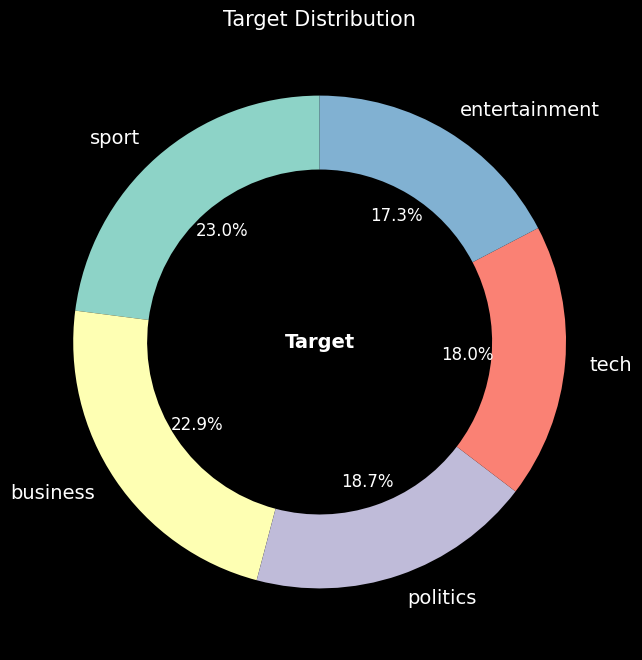

In [7]:
plt.style.use('dark_background')
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    data.category.value_counts(), labels=data.category.value_counts().index, autopct='%1.1f%%', startangle=90, 
    wedgeprops={'width': 0.3}
)
plt.text(0, 0, 'Target', ha='center', va='center', fontsize=14, fontweight='bold')
plt.title("Target Distribution", fontsize=15)
plt.setp(autotexts, size=12, color="white")
plt.setp(texts, size=14, color="white")
plt.show()

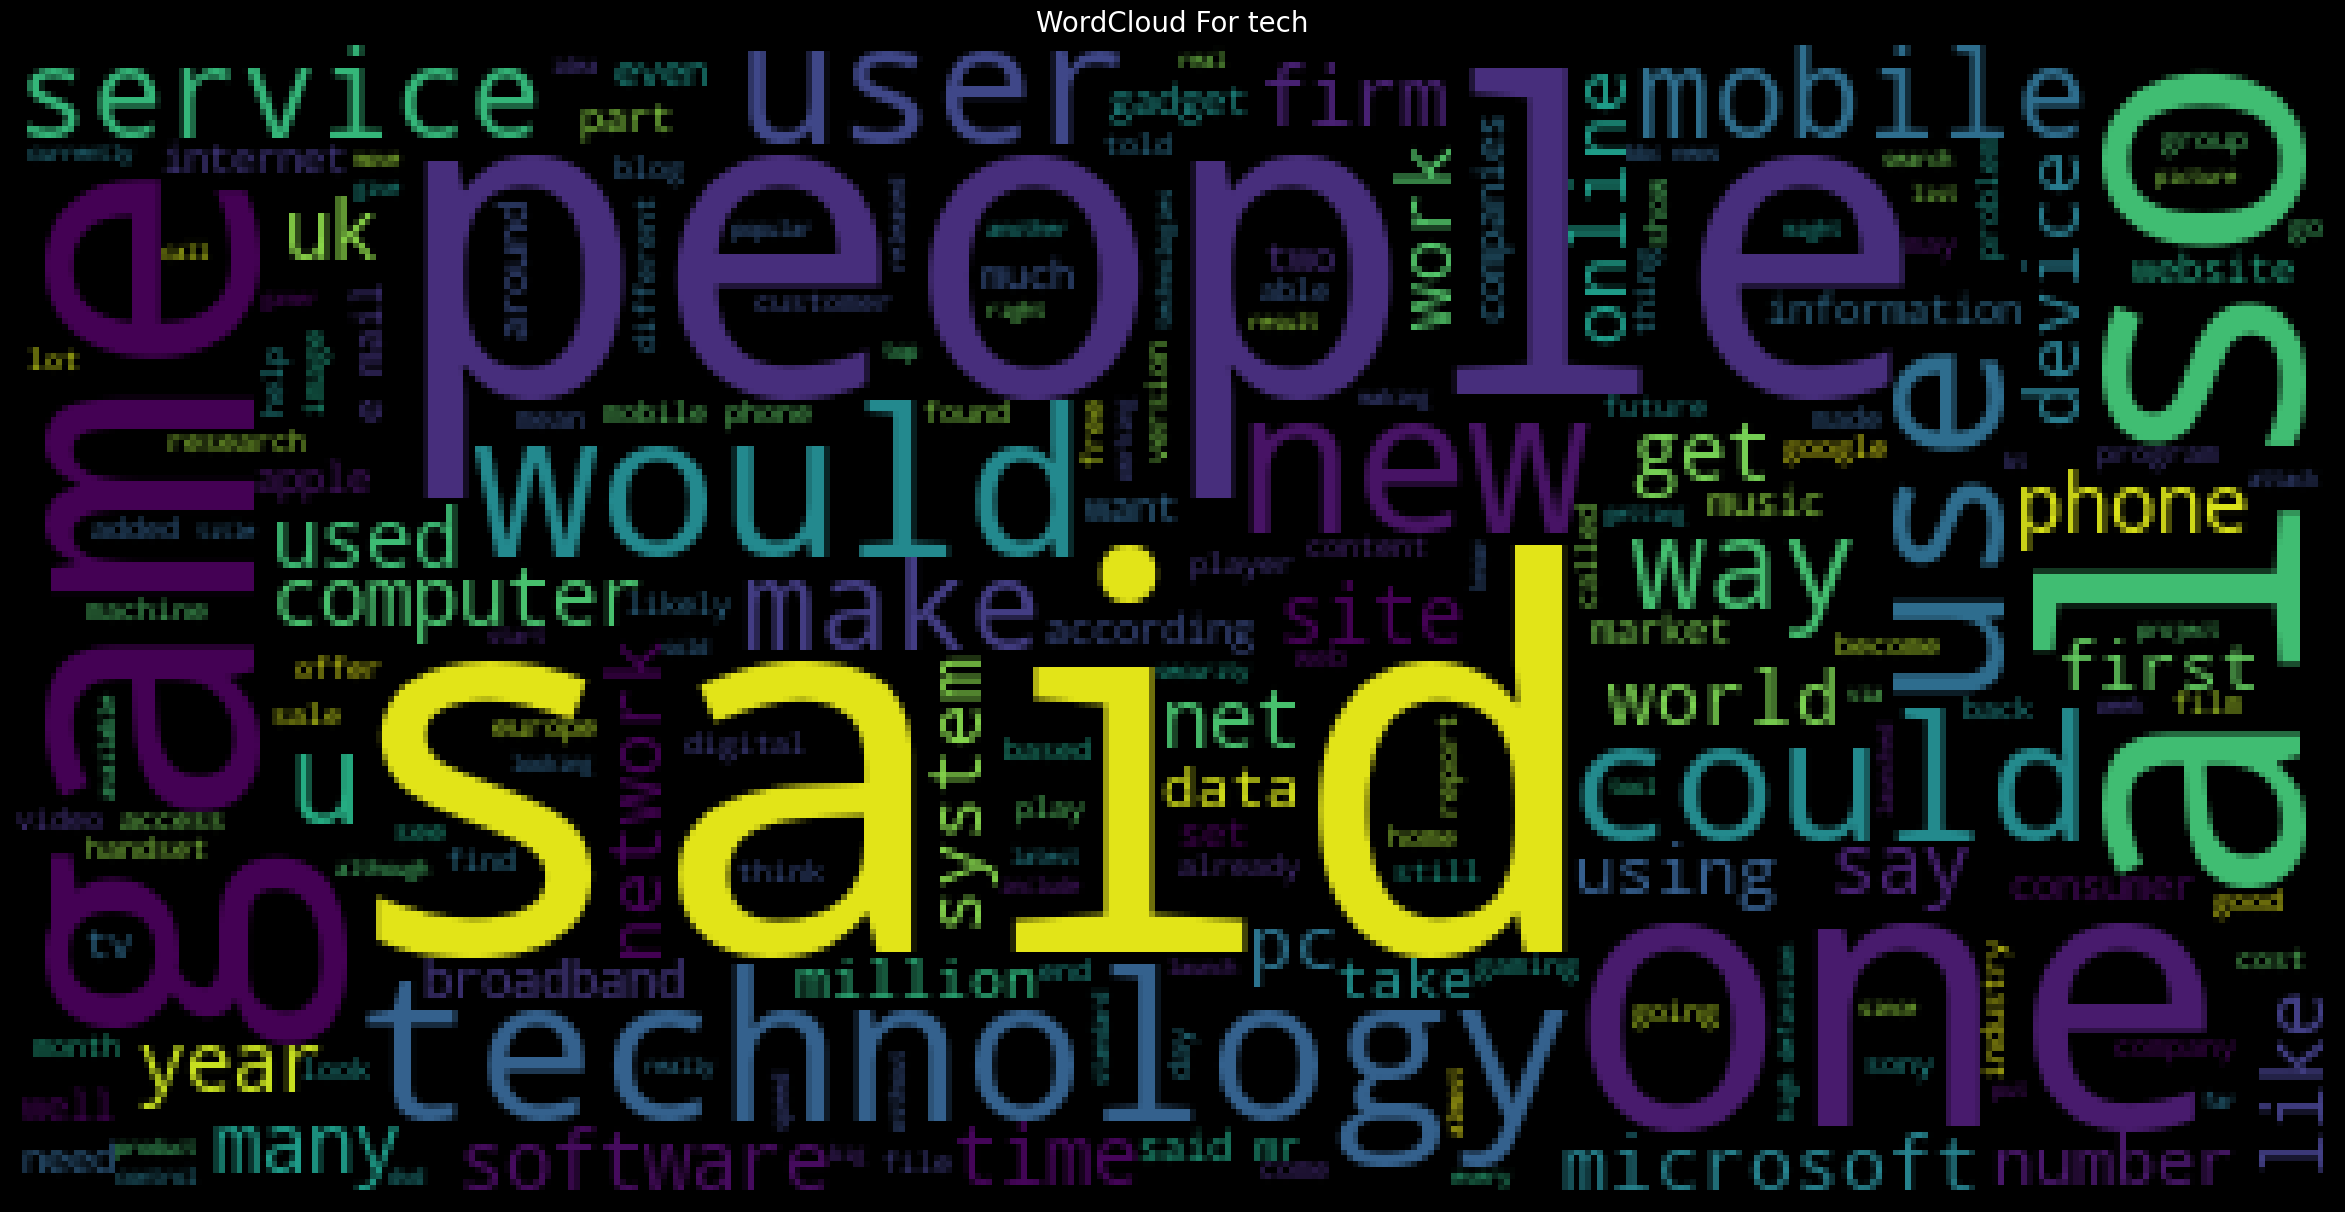

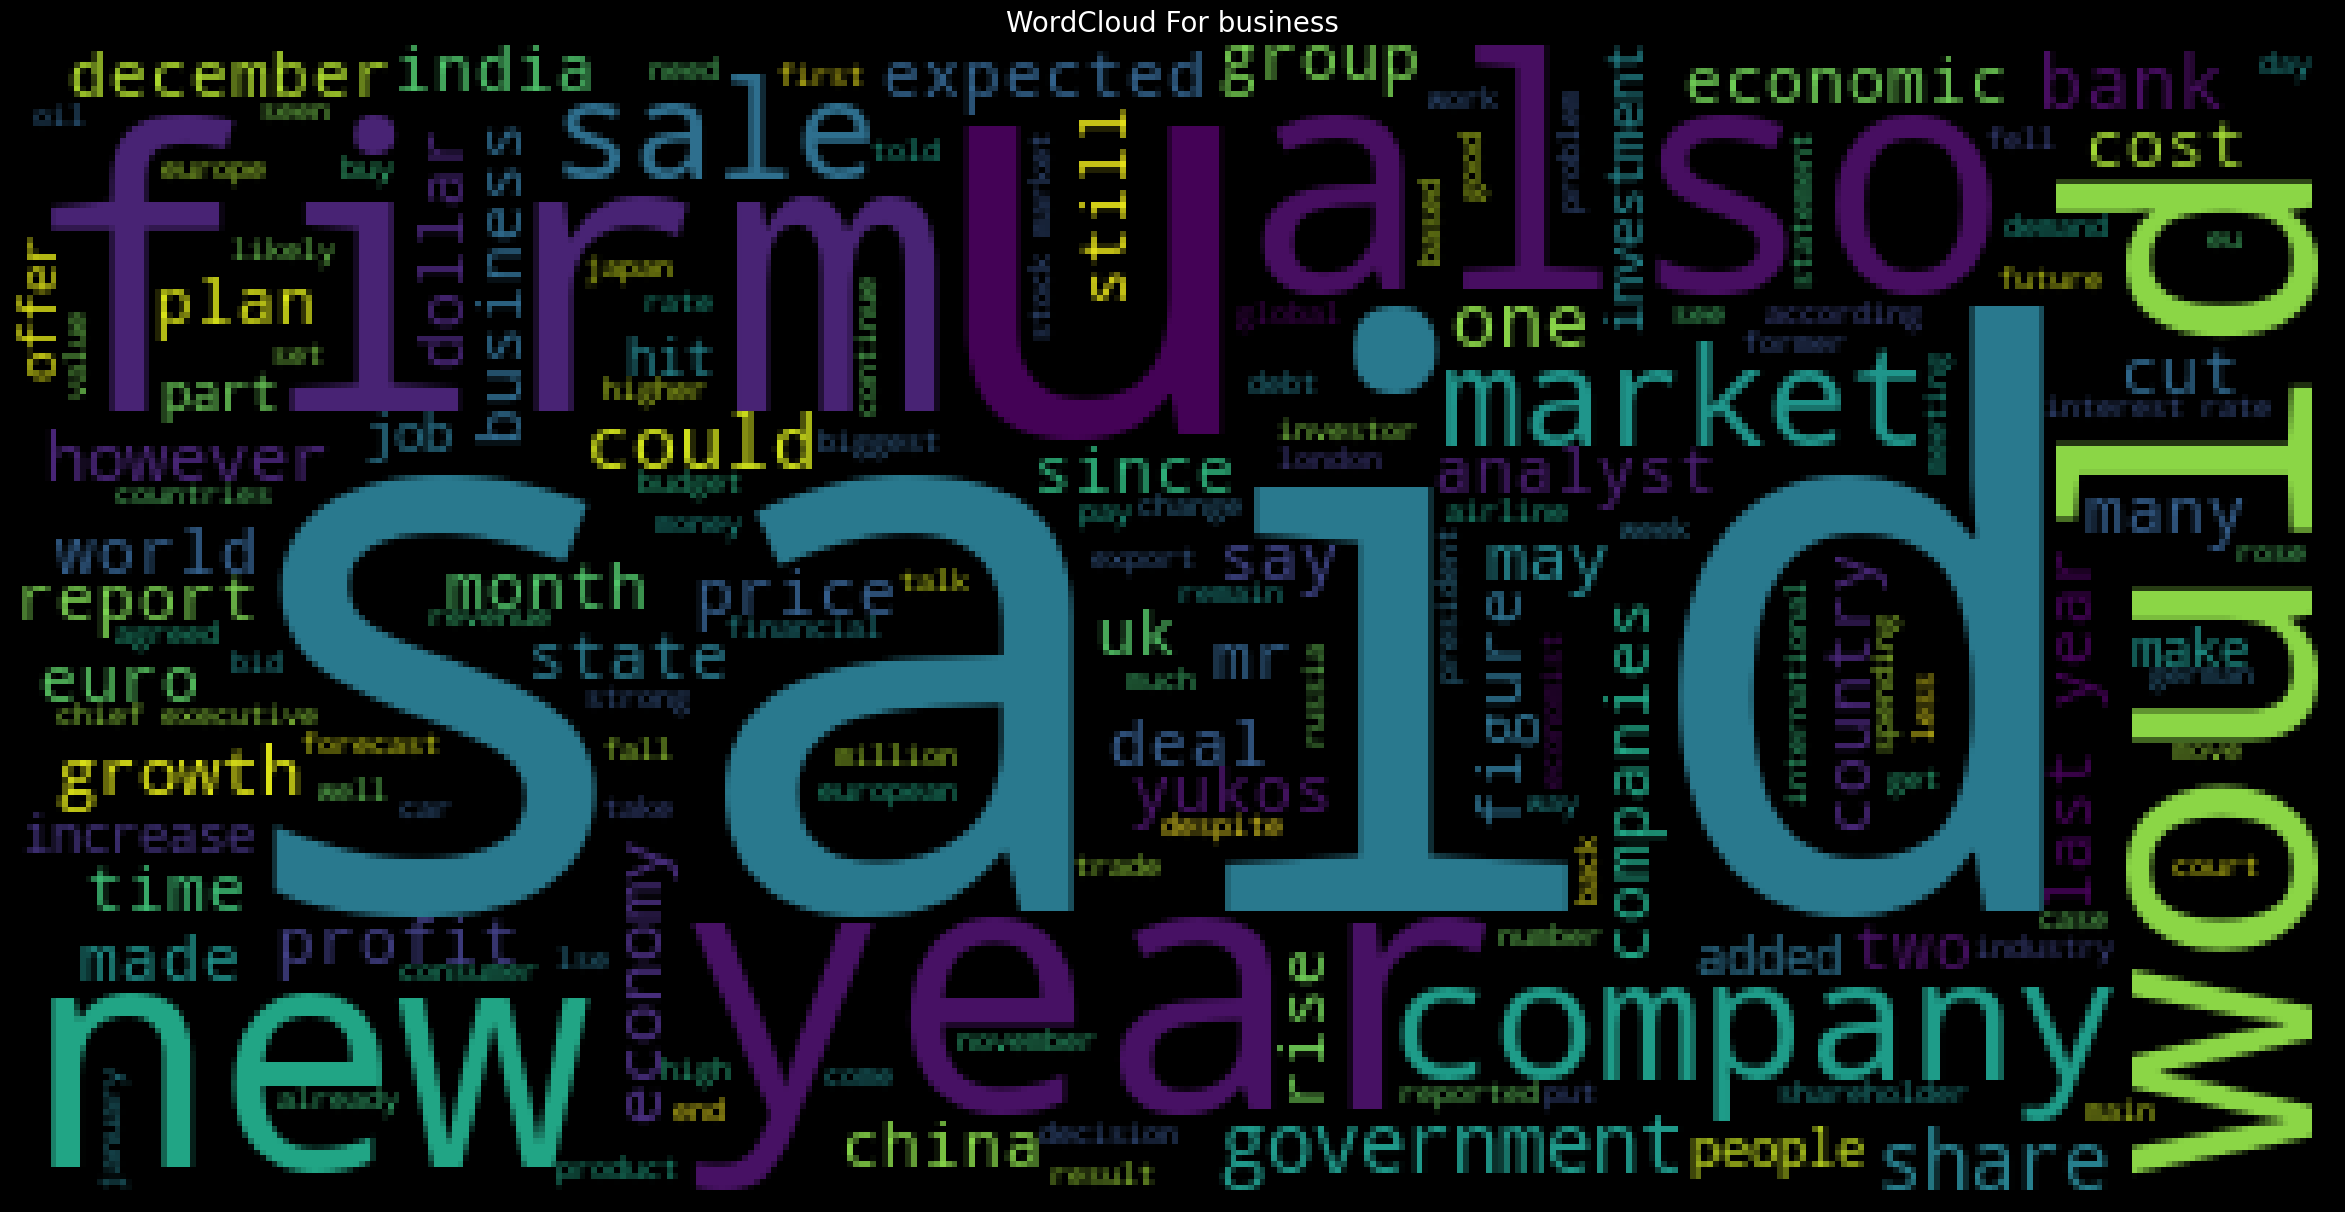

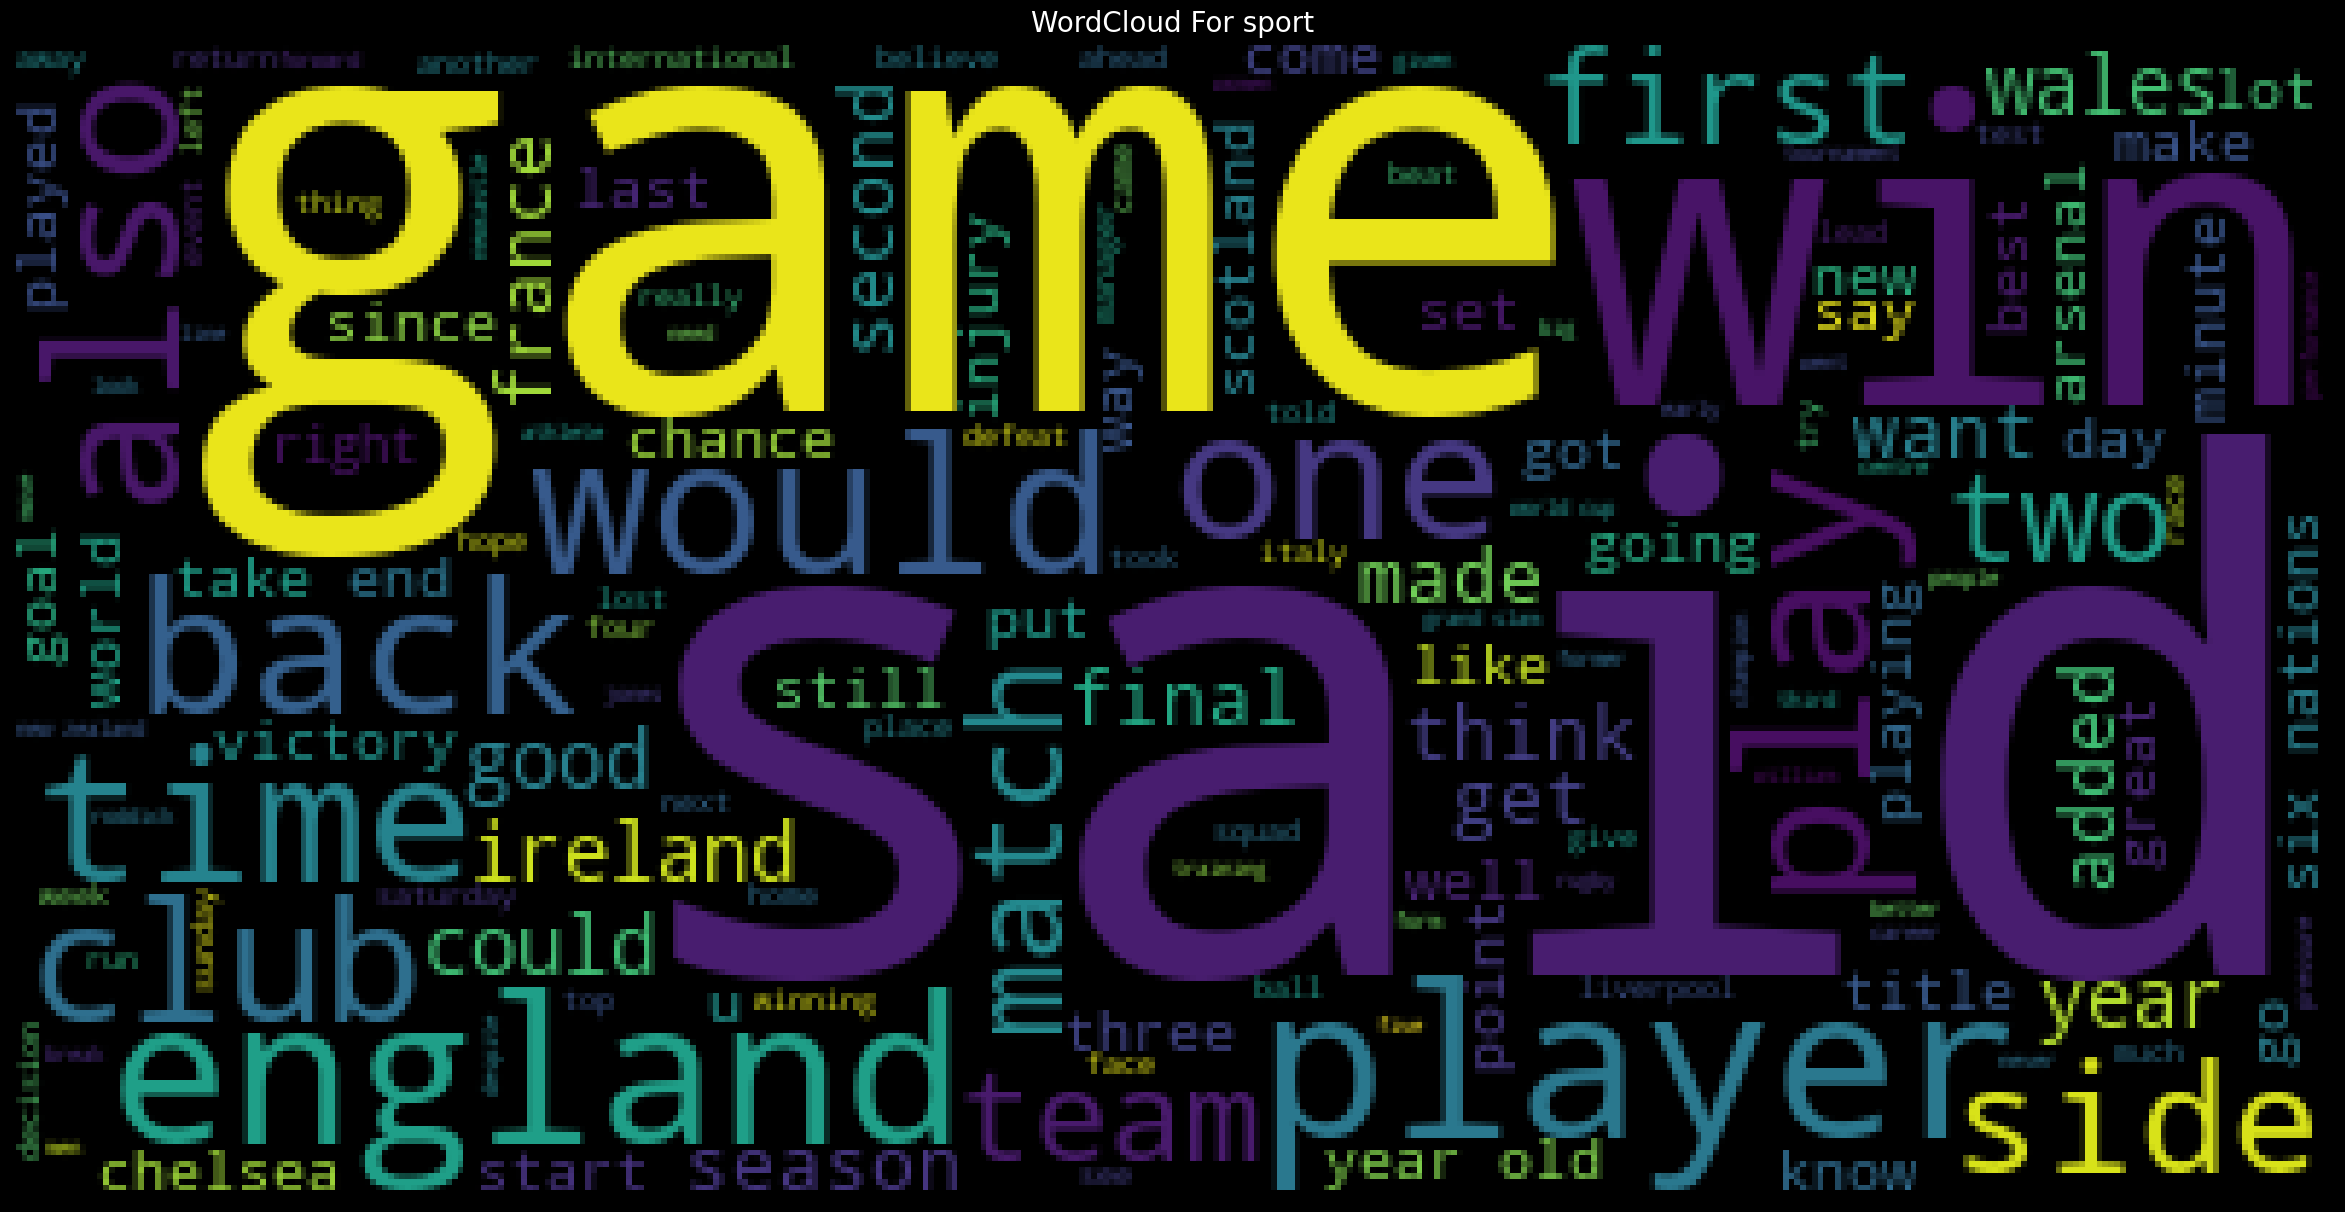

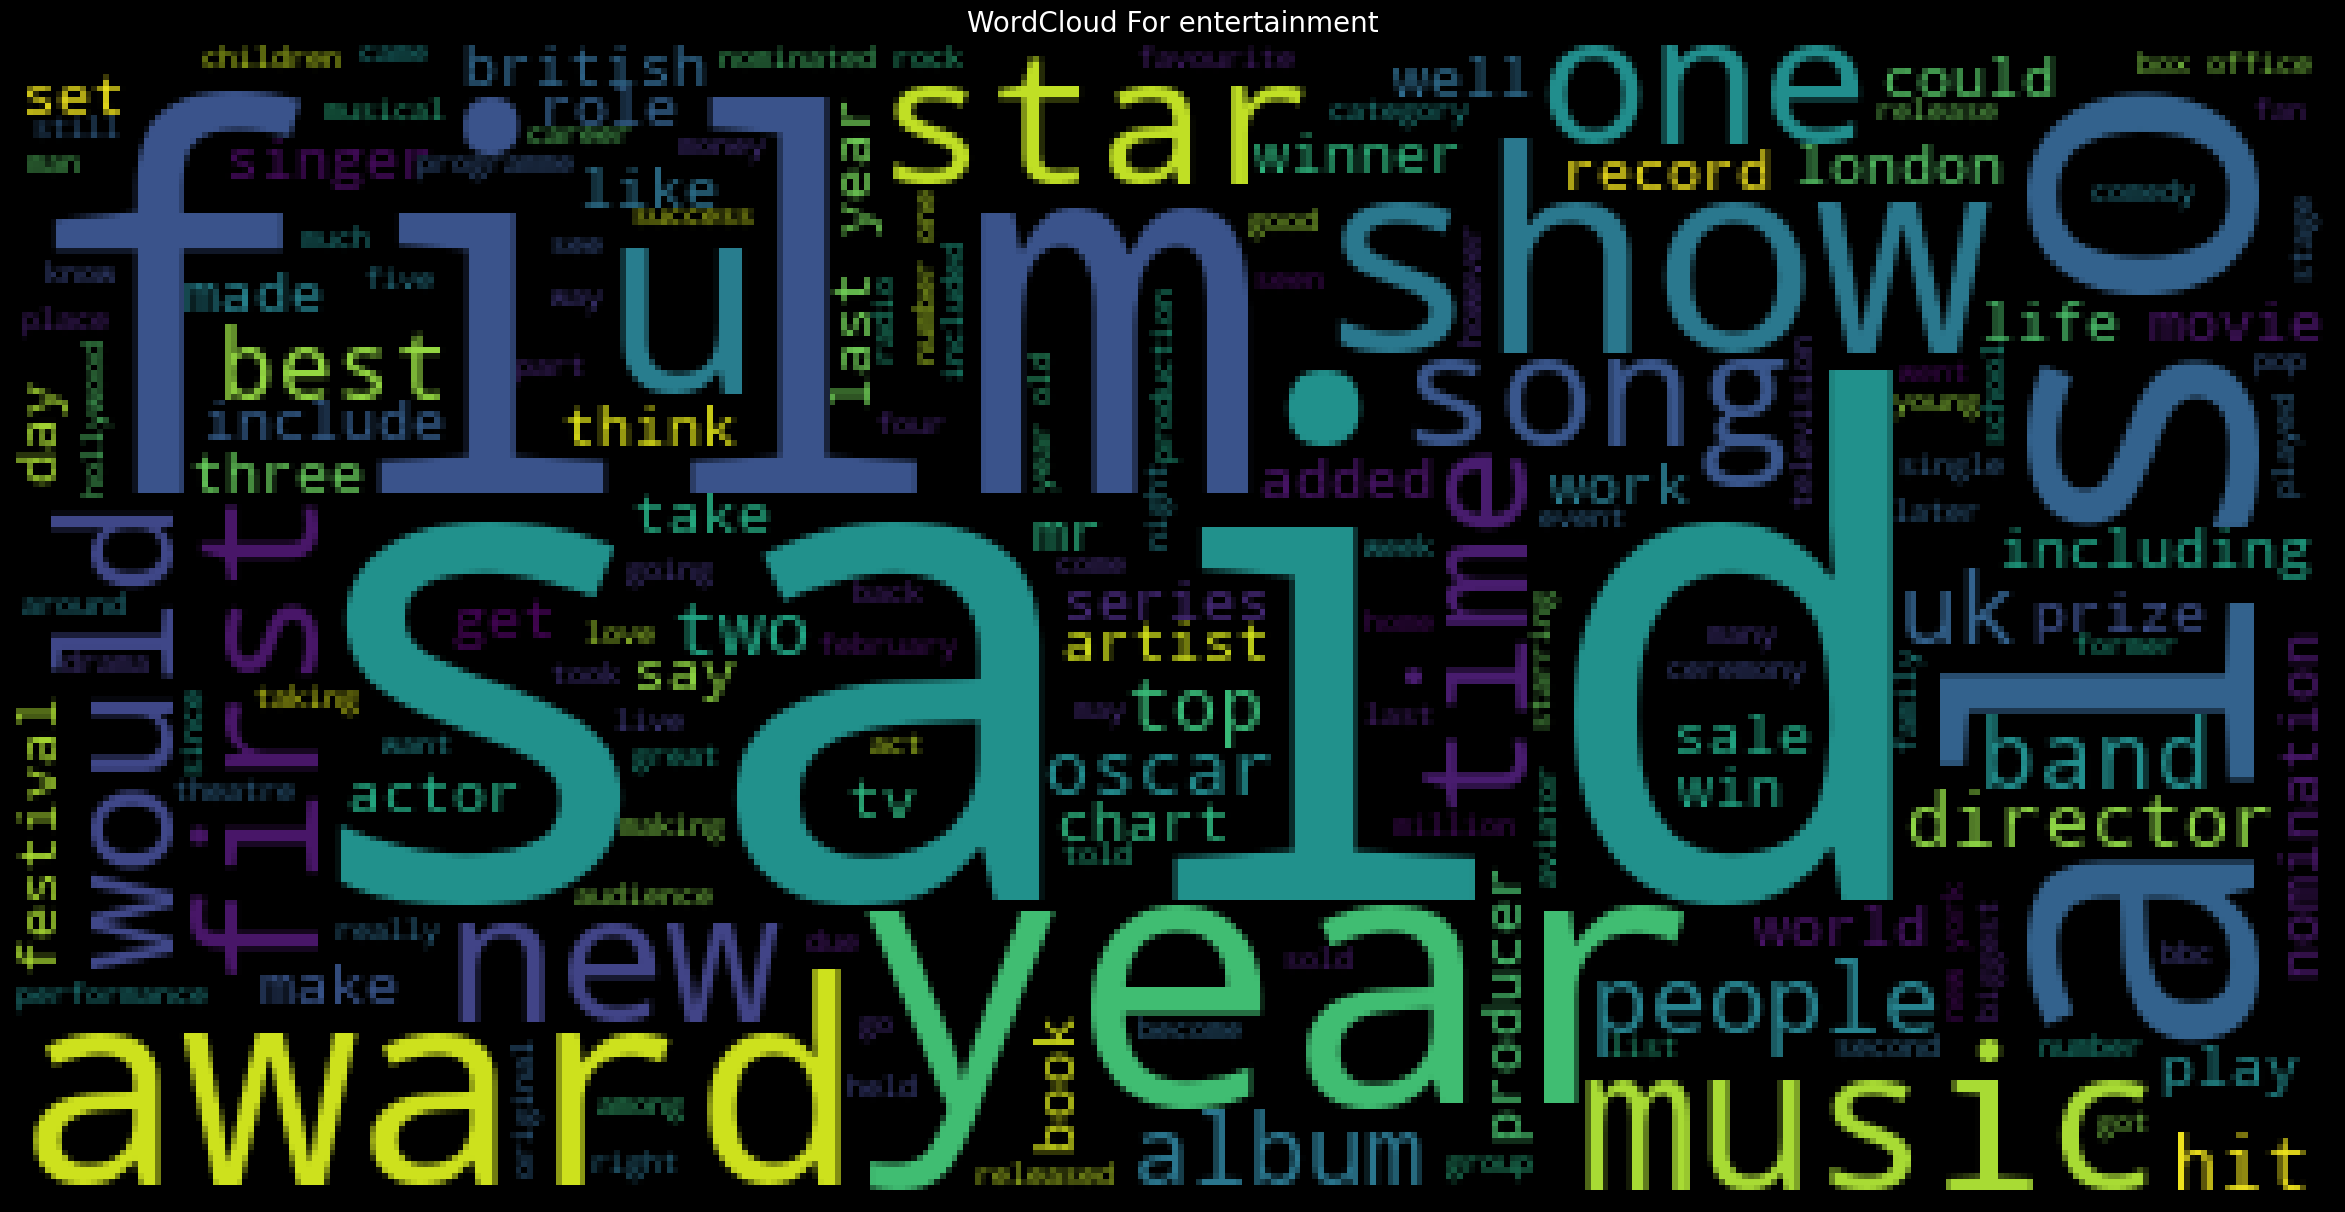

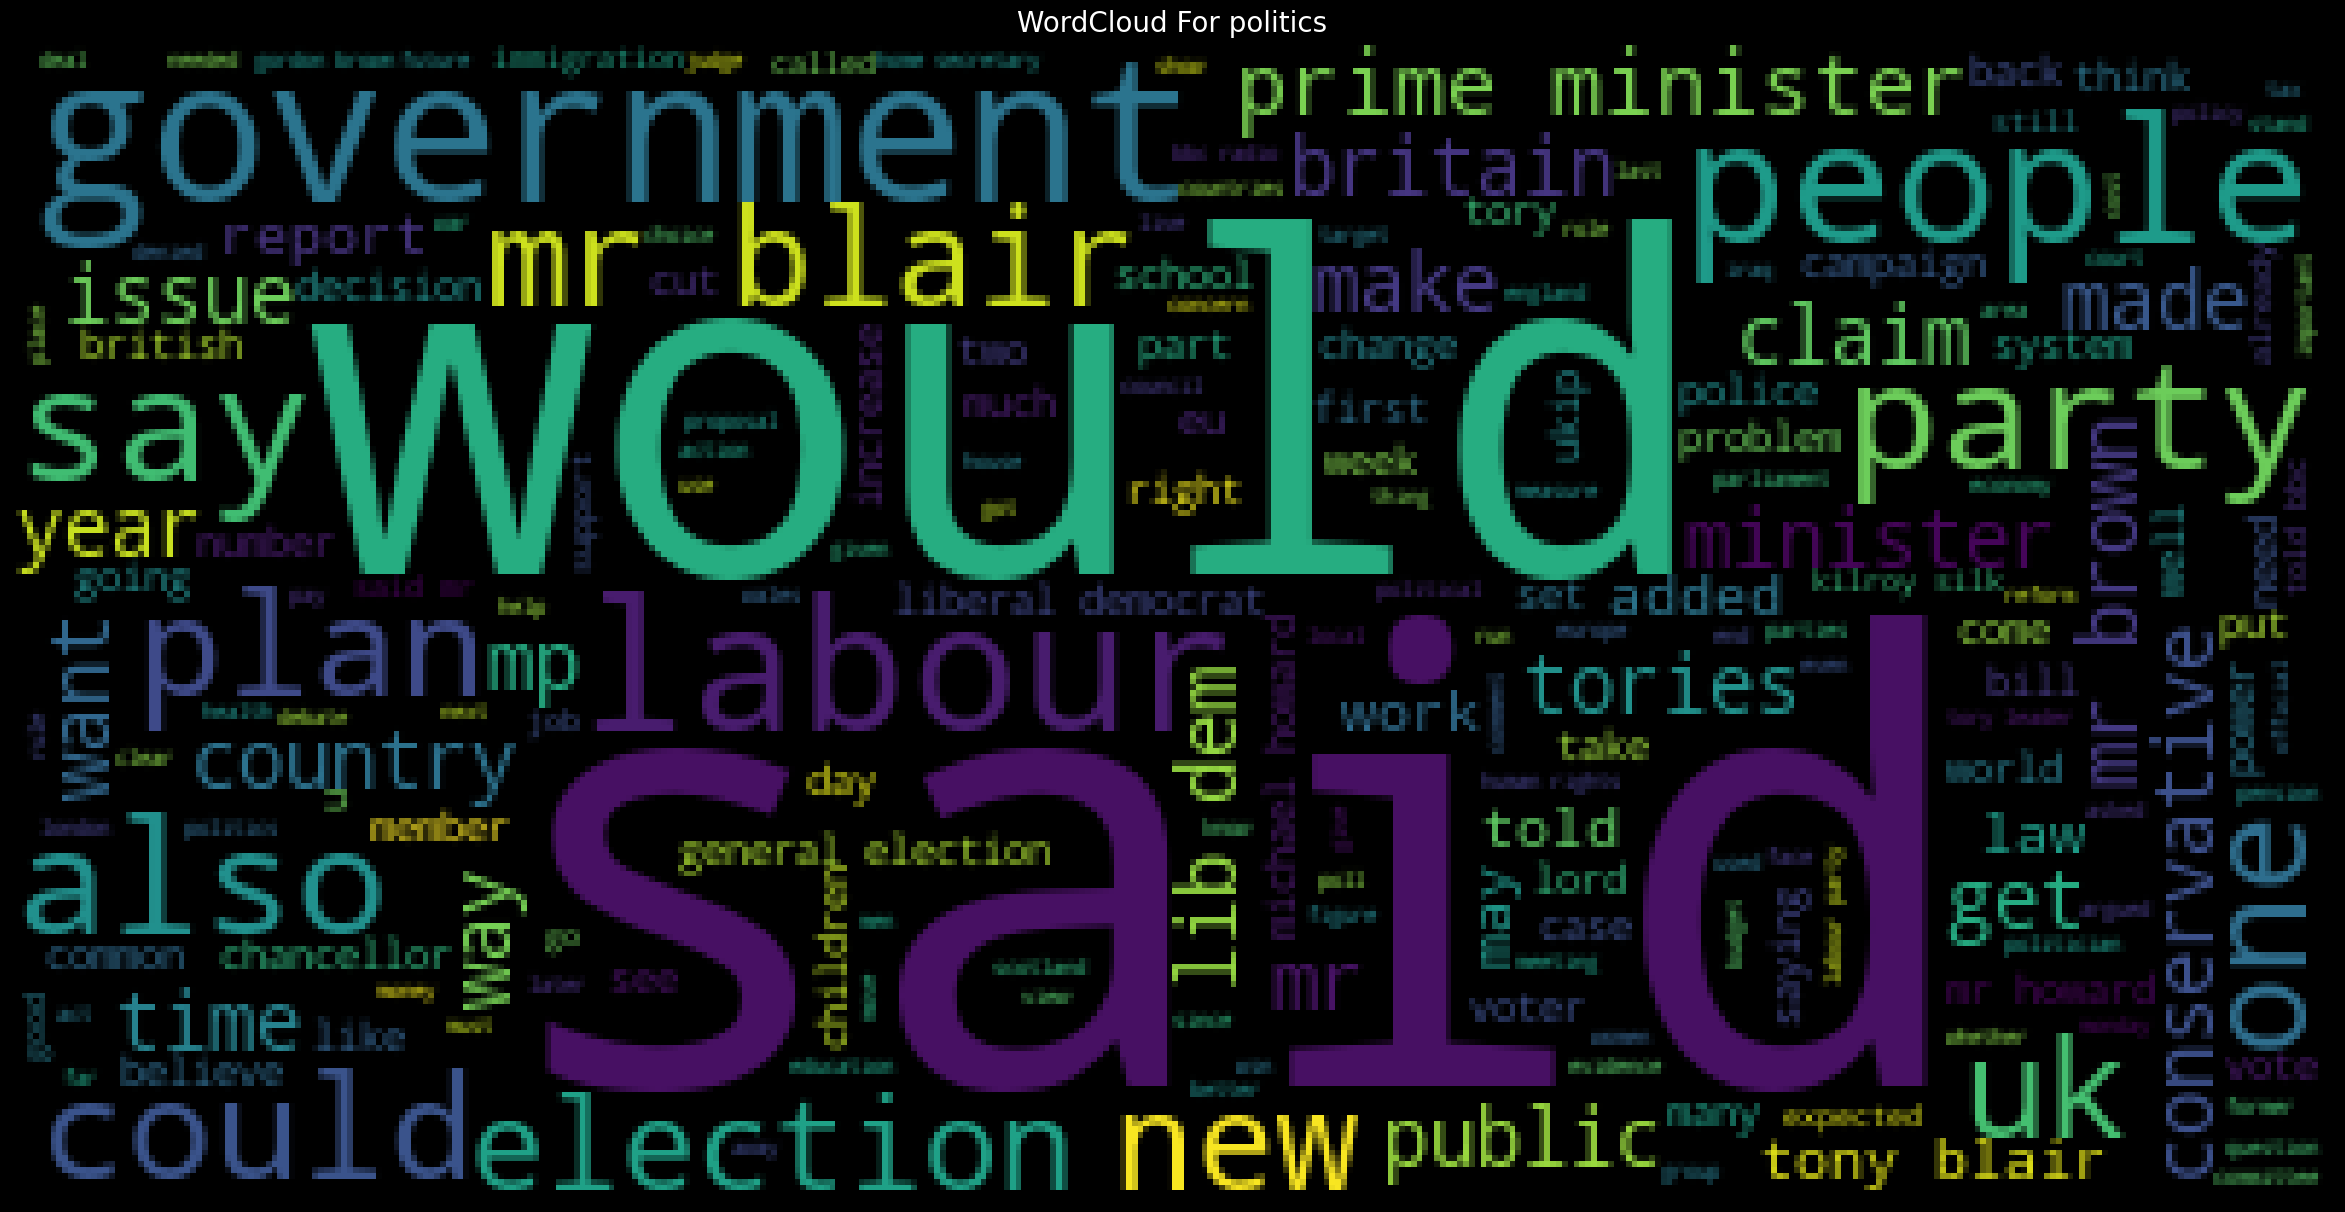

In [8]:
for value in data.category.unique():
    plt.figure(figsize=(30,30))
    plt.imshow(WordCloud(background_color = 'black',stopwords=set(stopwords.words('english'))).generate(" ".join(data.text[data.category==value])))
    plt.axis("off")
    plt.title(f"WordCloud For {value}",fontsize=20)
    plt.show()  

<a id="4"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Preprocessing</p></b></h1>

In [9]:
# NLTK English stopwords
english_stopwords = set(stopwords.words('english'))

def clean_bbc_news_text(text):
    """
    Cleans a given text by:
    - Removing HTML tags
    - Removing special characters and punctuation
    - Removing digits
    - Converting text to lowercase
    - Removing NLTK stopwords
    
    Args:
        text (str): The text to be cleaned.
    
    Returns:
        str: The cleaned text.
    """
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and punctuation (retain spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in english_stopwords]
    
    # Join words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [10]:
data.text = data.text.apply(clean_bbc_news_text)
data.head()

,category,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raids box office ocean twelve cri...


In [11]:
encoder = LabelEncoder()
data.category = encoder.fit_transform(data.category)
data.head()

,category,text
0,4,tv future hands viewers home theatre systems p...
1,0,worldcom boss left books alone former worldcom...
2,3,tigers wary farrell gamble leicester say rushe...
3,3,yeading face newcastle fa cup premiership side...
4,1,ocean twelve raids box office ocean twelve cri...


In [12]:
def Balance_data(data,text,target):
    pass

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.text,data.category, test_size=0.2, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (1780,)
X_test shape is  (445,)
y_train shape is  (1780,)
y_test shape is  (445,)


<a id="5"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Load Model & Tokenizer</p></b></h1>

In [14]:
model_name = 'bert-base-uncased'
distilbert_model = TFBertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
def tokenize_data(text, max_length = 200):
  return tokenizer(
                  text.tolist(),
                  max_length = max_length,
                  truncation = True,
                  padding = 'max_length',
                  return_tensors = 'tf'
                  )

In [16]:
X_train_data = tokenize_data(X_train)
X_train_data

{'input_ids': <tf.Tensor: shape=(1780, 200), dtype=int32, numpy=
array([[  101,  7513, 26740, ...,  6681, 10372,   102],
       [  101, 18856, 28418, ...,     0,     0,     0],
       [  101,  9805, 15710, ...,  5275, 16625,   102],
       ...,
       [  101, 23413,  2229, ...,     0,     0,     0],
       [  101,  2501,  2095, ...,     0,     0,     0],
       [  101,  5470,  8034, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1780, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1780, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [17]:
X_test_data = tokenize_data(X_test)
X_test_data

{'input_ids': <tf.Tensor: shape=(445, 200), dtype=int32, numpy=
array([[  101, 15117,  2379, ...,     0,     0,     0],
       [  101,  3036,  4981, ...,     0,     0,     0],
       [  101,  4684,  2015, ..., 14841,  6767,   102],
       ...,
       [  101,  7391,  2131, ..., 28831, 11183,   102],
       [  101, 15009,  4491, ...,  2349,  3677,   102],
       [  101,  4401,  2067, ...,  8040,  5668,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(445, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(445, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32

In [18]:
y_train1 = to_categorical(y_train, num_classes=5) 
y_test1 = to_categorical(y_test, num_classes=5) 

<a id="6"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Training</p></b></h1>

In [19]:
# Define input and attention mask
input_ids = Input(shape=(200,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(200,), dtype='int32', name='attention_mask')
# Wrap DistilBERT in a Lambda layer with explicit output shape
def distilbert_fn(inputs):
    return distilbert_model(input_ids=inputs[0], attention_mask=inputs[1]).last_hidden_state
distilbert_layer = Lambda(
    distilbert_fn,
    output_shape=(200, 768)  # Sequence length, hidden size of DistilBERT
)([input_ids, attention_mask])
# Extract CLS token output
cls_output = Lambda(lambda x: x[:, 0, :])(distilbert_layer)
# Add a dense layer for classification
num_classes = len(data.category.unique()) 
output = Dense(num_classes, activation='softmax')(cls_output)
# Build and compile the model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 200, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 768)       │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │      3,845 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,845 (15.02 KB)

 Trainable params: 3,845 (15.02 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Assuming X_train_data and y_train are in BatchEncoding and list/array formats
X_train_input_ids = np.array(X_train_data['input_ids'])
X_train_attention_mask = np.array(X_train_data['attention_mask'])
y_train = np.array(y_train)  # Ensure labels are in NumPy format
# Fit the model
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train1,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 706s 14s/step - accuracy: 0.4824 - loss: 1.4134 - val_accuracy: 0.8764 - val_loss: 0.7679
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 689s 14s/step - accuracy: 0.8904 - loss: 0.6746 - val_accuracy: 0.9270 - val_loss: 0.4706
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 690s 14s/step - accuracy: 0.9297 - loss: 0.4290 - val_accuracy: 0.9213 - val_loss: 0.3505
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 691s 14s/step - accuracy: 0.9398 - loss: 0.3208 - val_accuracy: 0.9382 - val_loss: 0.2929
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 694s 14s/step - accuracy: 0.9455 - loss: 0.2623 - val_accuracy: 0.9382 - val_loss: 0.2565
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 753s 14s/step - accuracy: 0.9461 - loss: 0.2431 - val_accuracy: 0.9438 - val_loss: 0.2293
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 694s 14s/step - accuracy: 0.9511 - loss: 0.2119 - val_accuracy: 0.9494 - val_loss: 0.2150
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 695s 14s/step - accuracy: 0.9592 - loss: 0.1904 - val_accuracy: 0.

In [21]:
hist = pd.DataFrame(history.history)
hist 

,accuracy,loss,val_accuracy,val_loss
0,0.659176,1.190184,0.876405,0.767939
1,0.904494,0.603845,0.926966,0.470612
2,0.933208,0.403377,0.921348,0.350526
3,0.944444,0.309584,0.938202,0.292855
4,0.943196,0.259481,0.938202,0.256461
5,0.955680,0.224900,0.943820,0.229286
6,0.956305,0.200803,0.949438,0.215030
7,0.963171,0.180996,0.949438,0.196624
8,0.965044,0.167325,0.955056,0.186306
9,0.961298,0.155075,0.949438,0.178656


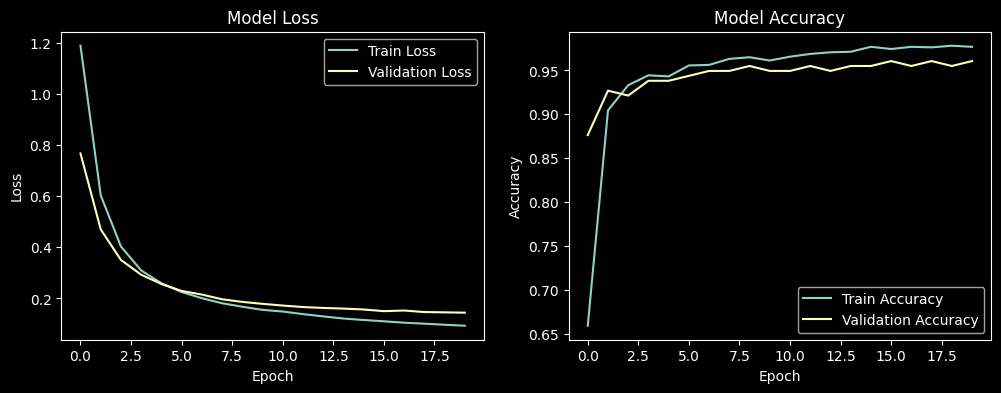

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<a id="7"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Evaluation</p></b></h1>

In [23]:
loss, accuracy = model.evaluate([X_test_data['input_ids'],X_test_data['attention_mask']], y_test1)
print(f'Model Loass : {loss}')
print(f'Model Accuracy : {accuracy * 100}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 173s 12s/step - accuracy: 0.9682 - loss: 0.0988
Model Loass : 0.0923907607793808
Model Accuracy : 97.30337262153625


In [24]:
predictions = model.predict([X_test_data['input_ids'],X_test_data['attention_mask']])
y_pred = np.argmax(predictions,axis=1)
y_pred[:10]

14/14 ━━━━━━━━━━━━━━━━━━━━ 177s 13s/step


array([0, 2, 4, 1, 3, 4, 2, 2, 3, 0])

In [25]:
class_names = encoder.classes_
class_names

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Confusion Matrix is : 
 [[ 82   0   2   1   2]
 [  1  83   0   0   1]
 [  0   0  90   0   1]
 [  0   0   1 106   0]
 [  1   0   2   0  72]]


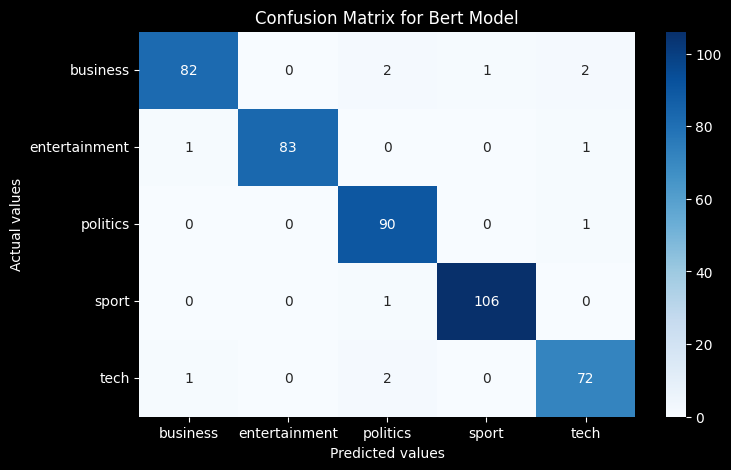

In [26]:
### Check model
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)
plt.figure(figsize=(8,5))
sns.heatmap(data=CM, annot=True,fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Bert Model')
plt.show()

In [27]:
ClassificationReport = classification_report(y_test, y_pred,target_names=class_names)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                 precision    recall  f1-score   support

     business       0.98      0.94      0.96        87
entertainment       1.00      0.98      0.99        85
     politics       0.95      0.99      0.97        91
        sport       0.99      0.99      0.99       107
         tech       0.95      0.96      0.95        75

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



<a id="8"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Predictive for Test</p></b></h1>

In [28]:
def Predictive(text):
    text = clean_bbc_news_text(text)
    token = tokenizer(
                  text,
                  max_length = 200,
                  truncation = True,
                  padding = 'max_length',
                  return_tensors = 'tf'
                  )
    output = np.argmax(model.predict([token['input_ids'],token['attention_mask']]),axis=1)
    return encoder.inverse_transform([output])[0]

In [29]:
test_sentence = "The stock market saw a significant increase today, with tech companies leading the way."
result = Predictive(test_sentence)
print(f"The predicted category is: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
The predicted category is: business


In [30]:
test_sentence = "The national football team secured a thrilling victory in the championship final last night."
result = Predictive(test_sentence)
print(f"The predicted category is: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
The predicted category is: sport


In [31]:
test_sentence = "The movie's release is set to break box office records this weekend, with fans eagerly awaiting the premiere."
result = Predictive(test_sentence)
print(f"The predicted category is: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
The predicted category is: entertainment


<center><span style="font-family:Palatino; font-size:22px;"><i>Like this? <span style="color:#DC143C;">Upvote and Comment!</span> </i>🌊 End</span> </center>